# FAA Database Query

## This python script lets you request data from the FAA database in a simple way and allows you to visualize it

#### Set up the query

In [1]:
import requests
import pandas as pd
import numpy as np

data_atrs = {
    'keylist':'LOCID%2CYYYYMM',
    'line': '',
    'cmd' : 'tot',
    'avgdays': '1'
    }
line_atrs  = {
    'start_date' : '', #YYYYMM
    'end_date' : '', #YYYYMM
    'airports' : '' #ATL%27%2C%27+BOS%27%2C%27+...+SLC%27%2C%27+TPA
    }

airport_cats = pd.read_csv(open('airports.csv'))


#### Enter the parameters for the data you want

In [5]:
line_atrs['start_date'] = input('enter start date in yyyymm format: ')
line_atrs['end_date'] = input('enter end date in yyyymm format: ')

airports = input('enter aiport 3 letter codes in all caps with space in between\nOR\nenter one of the following categories {}: '\
                 .format(airport_cats.columns.values)).split(' ')


enter start date in yyyymm format: 200001
enter end date in yyyymm format: 202004
enter aiport 3 letter codes in all caps with space in between
OR
enter one of the following categories ['all' 'ASPM_77' 'OPSNET_45' 'Core']: Core


#### Format query and request data

In [6]:
if airports in airport_cats.columns.values:
    airports = [apt for apt in airport_cats[airports[0]] if apt != 'none'][1:-1]
line_atrs['airports'] = ''
for airport in airports:
    line_atrs['airports']+=airport+'%27%2C%27+'

line_atrs['airports'] = line_atrs['airports'][:-10]

data_atrs['line'] = 'SELECT+LOCID%2CYYYYMM+FROM+OPSNETSUMS+WHERE+YYYYMM%3E%3D{}+AND+YYYYMM%3C%3D{}+AND+LOCID+IN+%28%27+{}+%27%29+GROUP+BY+LOCID%2CYYYYMM+ORDER+BY+LOCID%2CYYYYMM'
data_atrs['line'] = data_atrs['line'].format(line_atrs['start_date'],line_atrs['end_date'],line_atrs['airports'])


data_param = ''
for atr in data_atrs:
    data_param+=atr+'='+data_atrs[atr]+'&'

headers = { 
        'Content-Type': 'application/x-www-form-urlencoded'
    }

print('sending request...')

r = requests.post('https://aspm.faa.gov/tfms/sys/tfms-server-x.asp', headers=headers,data= data_param)
print('response: '+ str(r))


sending request...
response: <Response [200]>


#### Display data in a table

In [7]:
from bs4 import BeautifulSoup as bs

raw_html_data = str(r.content)

soup = bs(raw_html_data, 'html.parser')



raw_data = soup.find_all('tr')[3:-5]

airports_index = {}

apt = raw_data[0].findChildren()[1].text.strip()
start = 0

for i in range(1,len(raw_data)):
    if(apt == raw_data[i].findChildren()[1].text.strip()):
        continue
    airports_index[apt]= '{}:{}'.format(start,i)
    apt = raw_data[i].findChildren()[1].text.strip()
    start = i
    
airports_index[apt]= '{}:{}'.format(start,len(raw_data))


data_headers = []

for child in soup.find_all('tr')[1].findChildren('td'):
    if child.text.isalpha():
        data_headers.append(child.text)
data_headers=data_headers[1:]

airports_data = {}


for apt in airports_index:
    data = []
    idx = airports_index[apt].split(':')
    for row in raw_data[int(idx[0]):int(idx[1])]:
        children = row.findChildren()
        row_data = [children[4].text,children[12].text,children[20].text,children[23].text]
        data.append(row_data)

    airports_data[apt] = pd.DataFrame(data= data, columns=data_headers)

    print('\nAirport: {}'.format(apt))
    print(airports_data[apt])


Airport: ATL - Atlanta
        Date Departure Arrival TotalOperations
0    01/2000    36,714  36,656          73,370
1    02/2000    37,050  37,002          74,052
2    03/2000    40,628  40,578          81,206
3    04/2000    38,577  38,528          77,105
4    05/2000    39,115  39,067          78,182
..       ...       ...     ...             ...
238  12/2019    37,103  37,060          74,163
239  01/2020    36,765  36,728          73,493
240  02/2020    34,225  34,192          68,417
241  03/2020    30,997  30,960          61,957
242  04/2020    10,212  10,194          20,406

[243 rows x 4 columns]

Airport: BOS - Boston
        Date Departure Arrival TotalOperations
0    01/2000    18,471  18,424          36,895
1    02/2000    18,992  18,937          37,929
2    03/2000    21,466  21,404          42,870
3    04/2000    19,987  19,923          39,910
4    05/2000    21,810  21,750          43,560
..       ...       ...     ...             ...
238  12/2019    17,015  16,962      


Airport: MIA - Miami
        Date Departure Arrival TotalOperations
0    01/2000    22,194  22,140          44,334
1    02/2000    21,636  21,556          43,192
2    03/2000    23,566  23,495          47,061
3    04/2000    22,591  22,520          45,111
4    05/2000    21,747  21,690          43,437
..       ...       ...     ...             ...
238  12/2019    19,243  19,199          38,442
239  01/2020    19,105  19,051          38,156
240  02/2020    18,062  17,996          36,058
241  03/2020    14,689  14,641          29,330
242  04/2020     5,290   5,237          10,527

[243 rows x 4 columns]

Airport: MSP - Minneapolis
        Date Departure Arrival TotalOperations
0    01/2000    20,740  20,664          41,404
1    02/2000    20,440  20,377          40,817
2    03/2000    22,016  21,947          43,963
3    04/2000    21,144  21,077          42,221
4    05/2000    21,966  21,901          43,867
..       ...       ...     ...             ...
238  12/2019    16,508  16,446   

#### Display data in a chart

enter one of the following categories to plot [all, Arrival, Departure, TotalOperations]: all
Airport: ATL - Atlanta


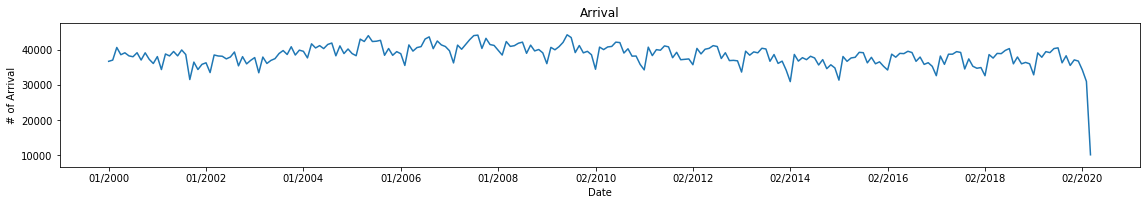

Airport: BOS - Boston


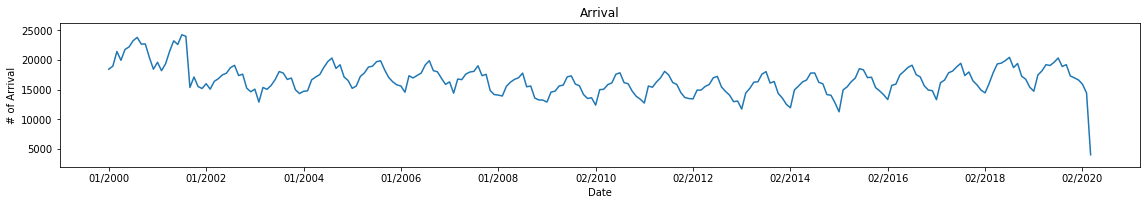

Airport: BWI - Baltimore


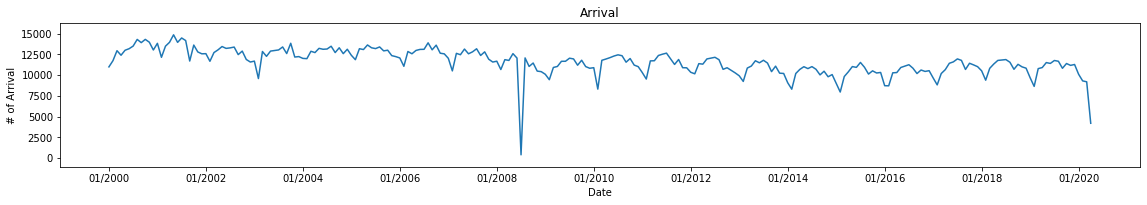

Airport: CLT - Charlotte


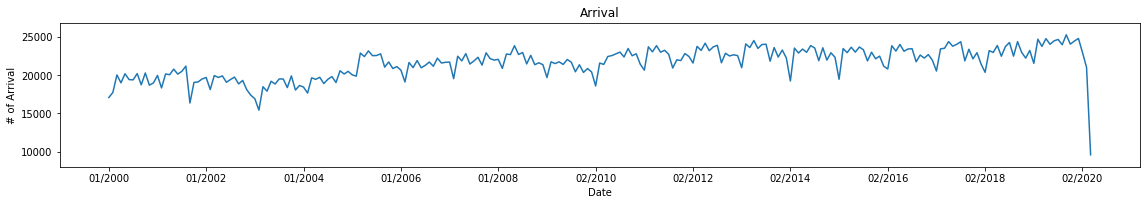

Airport: DCA - Washington


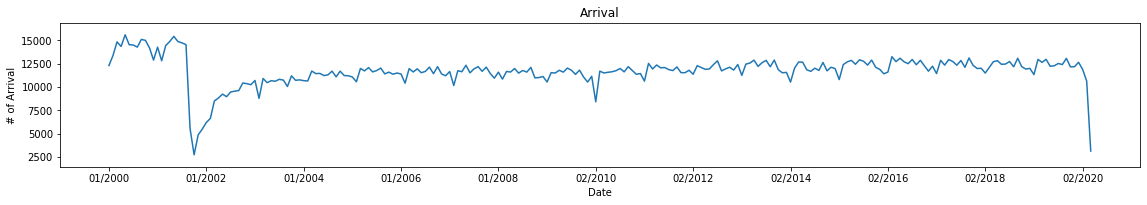

Airport: DEN - Denver


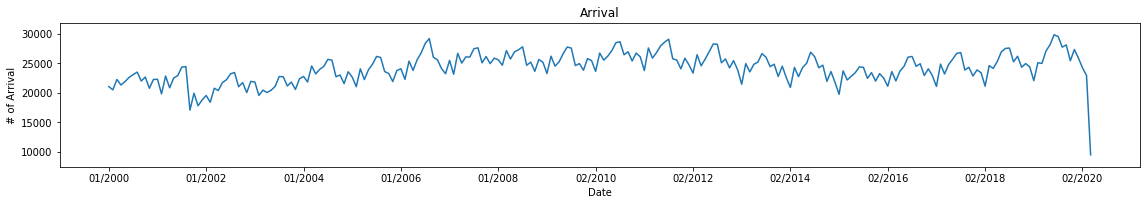

Airport: DFW - Dallas/Ft. Worth


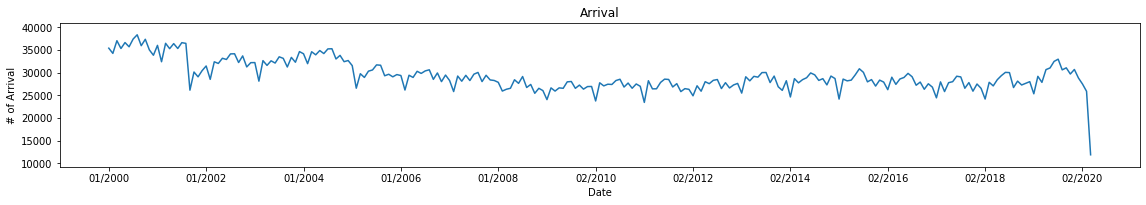

Airport: DTW - Detroit


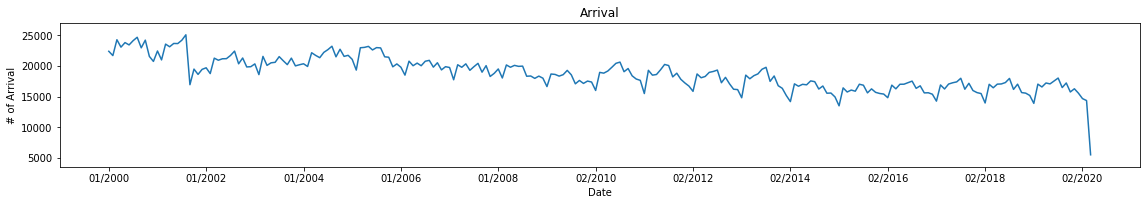

Airport: EWR - Newark


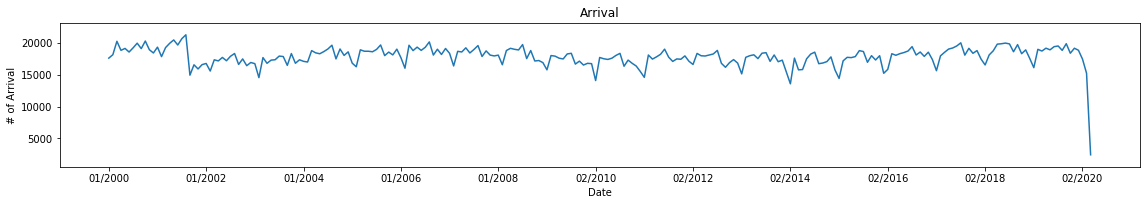

Airport: FLL - Fort Lauderdale


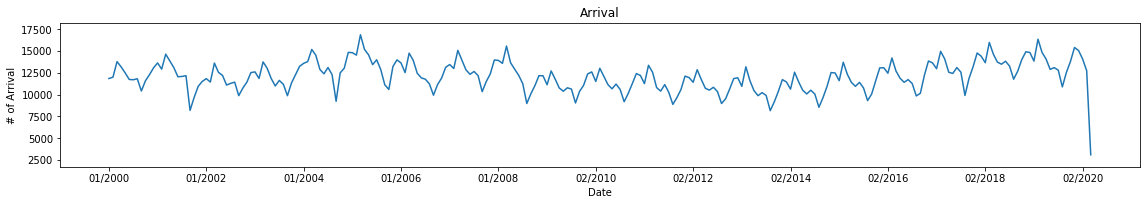

Airport: HNL - Honolulu


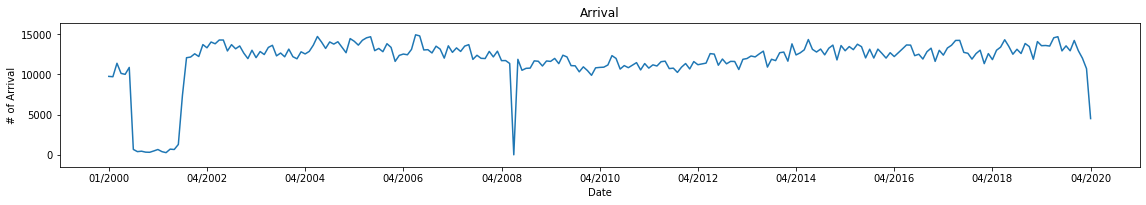

Airport: IAD - Washington


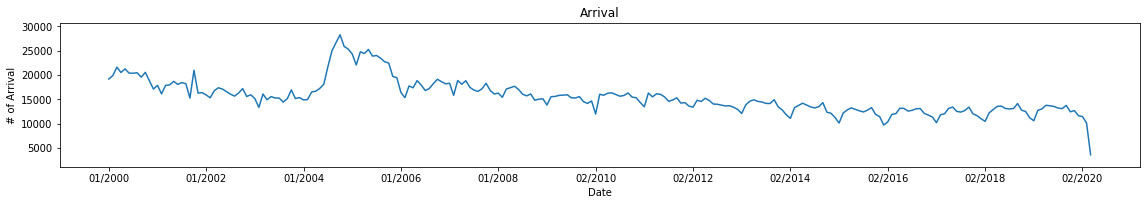

Airport: IAH - Houston


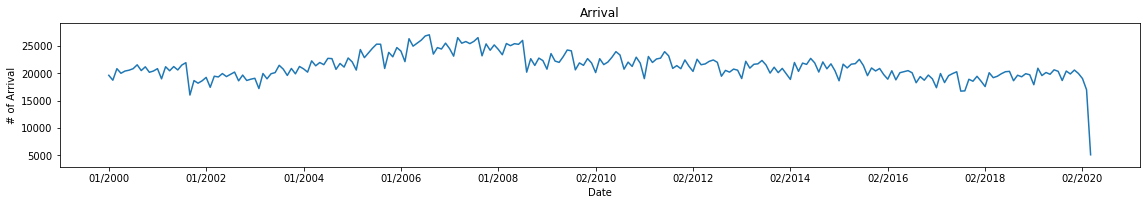

Airport: JFK - New York


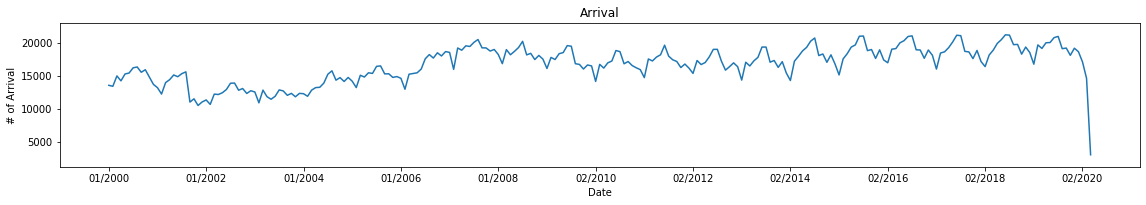

Airport: LAS - Las Vegas


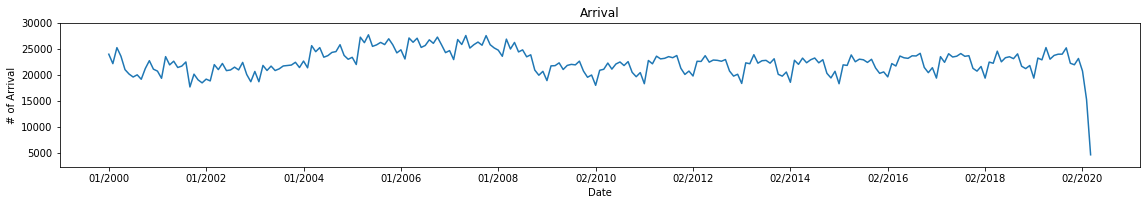

Airport: LAX - Los Angeles


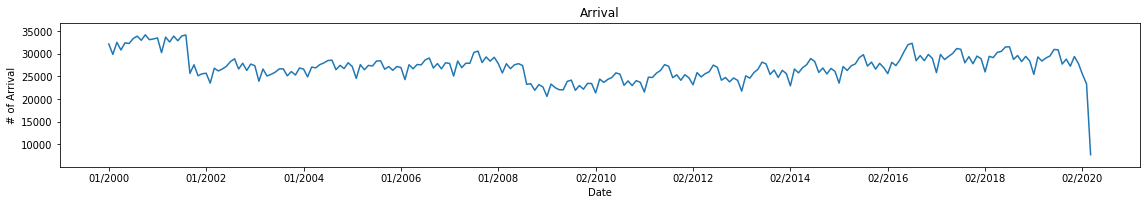

Airport: LGA - New York


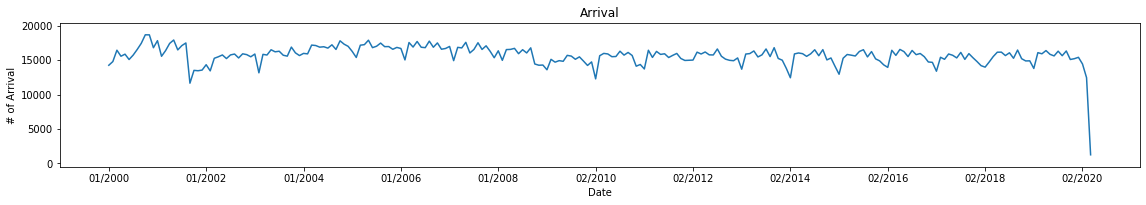

Airport: MCO - Orlando


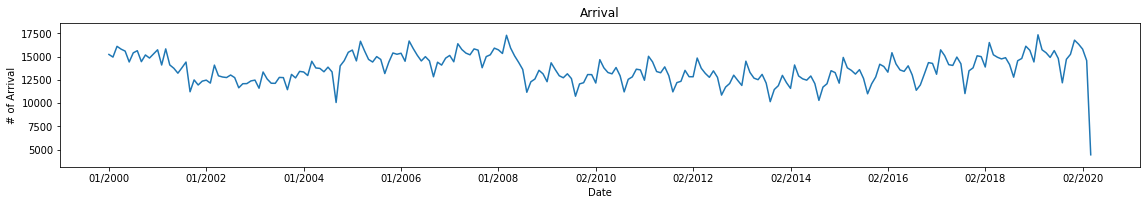

Airport: MDW - Chicago


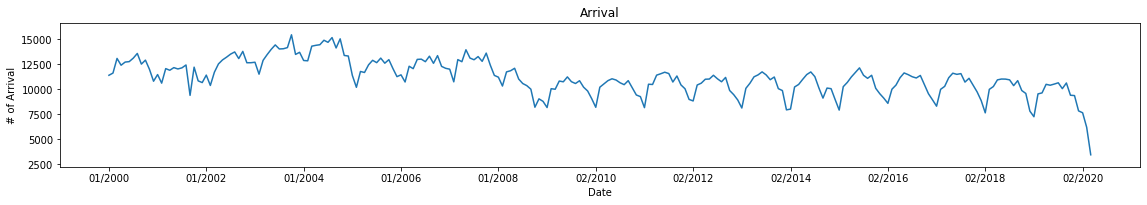

Airport: MEM - Memphis


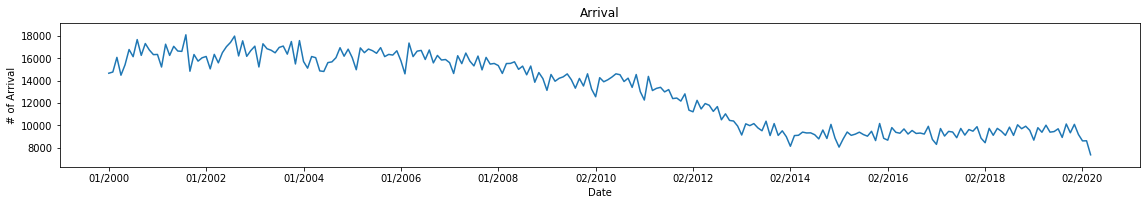

Airport: MIA - Miami


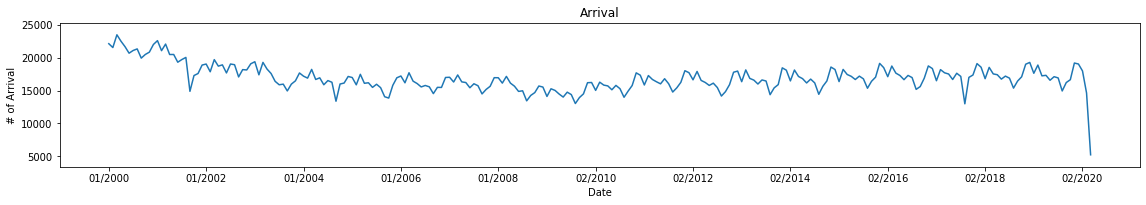

Airport: MSP - Minneapolis


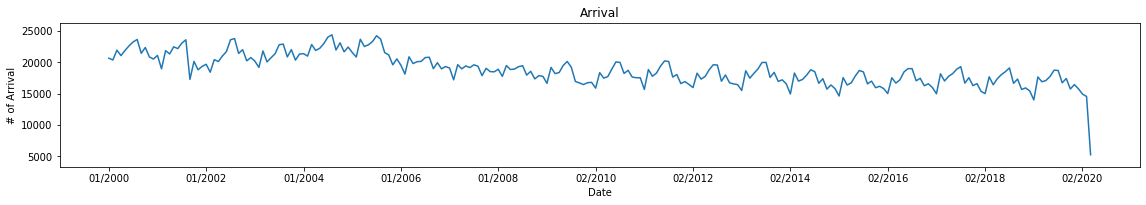

Airport: ORD - Chicago


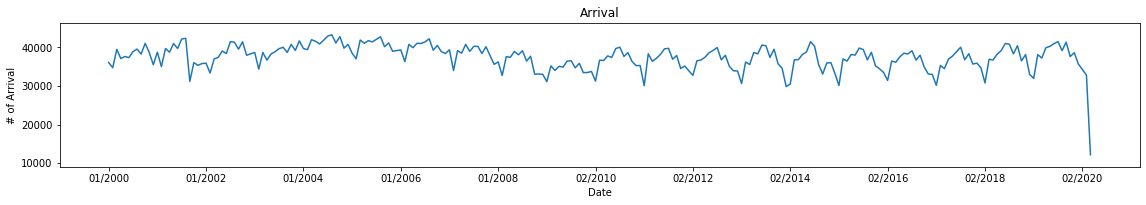

Airport: PHL - Philadelphia


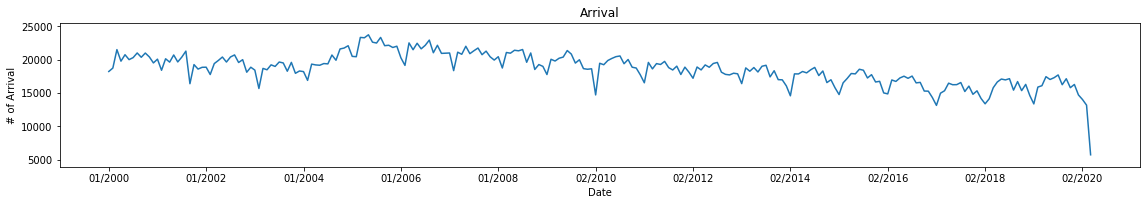

Airport: PHX - Phoenix


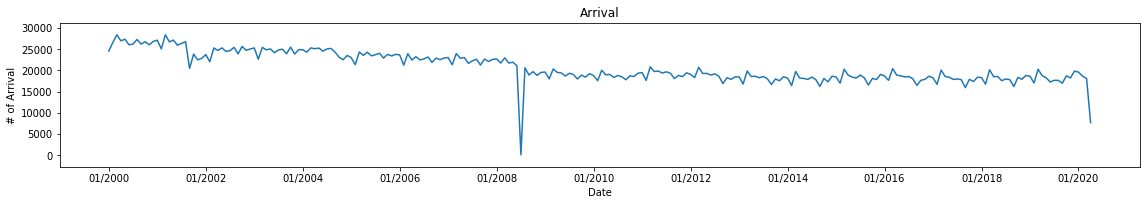

Airport: SAN - San Diego


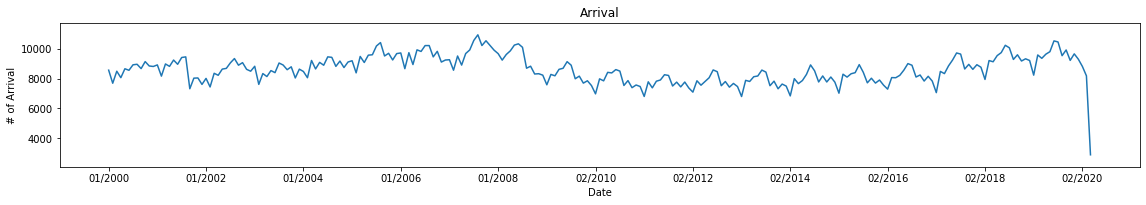

Airport: SEA - Seattle


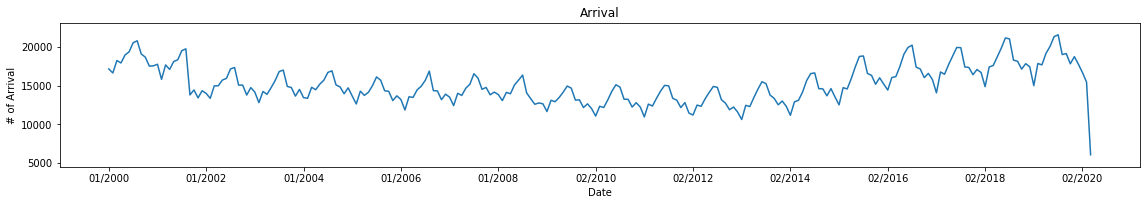

Airport: SFO - San Francisco


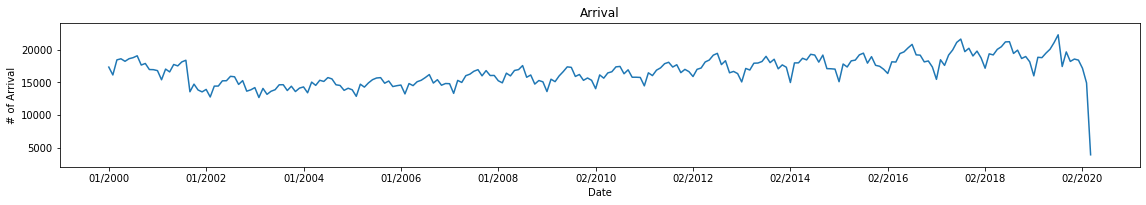

Airport: SLC - Salt Lake City


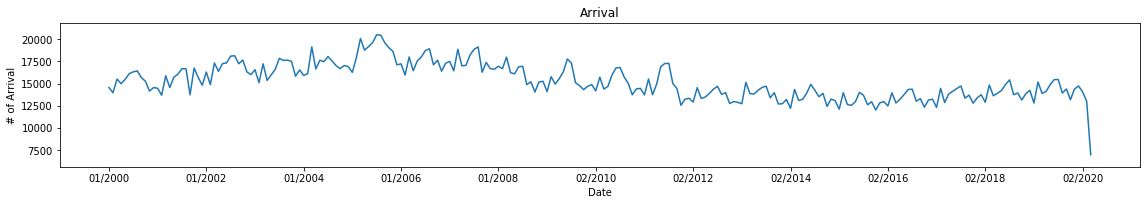

Airport: TPA - Tampa


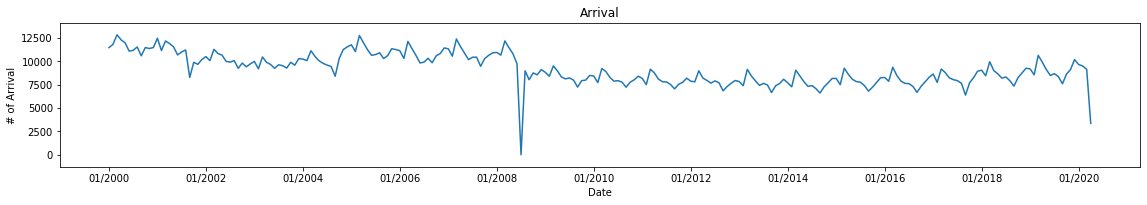

Airport: ATL - Atlanta


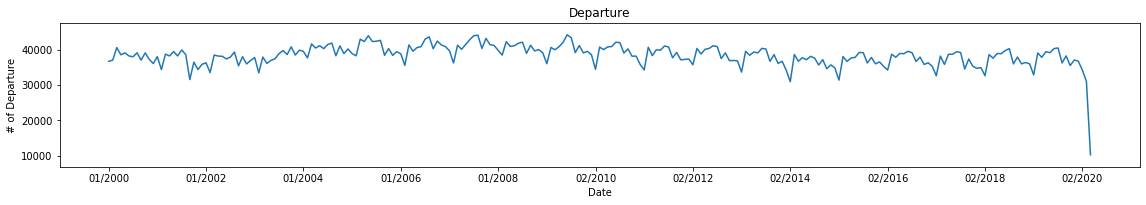

Airport: BOS - Boston


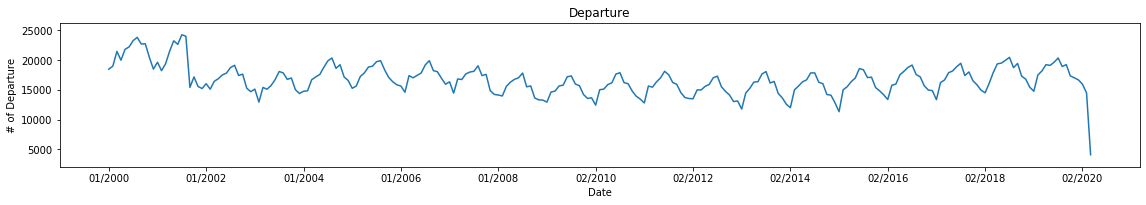

Airport: BWI - Baltimore


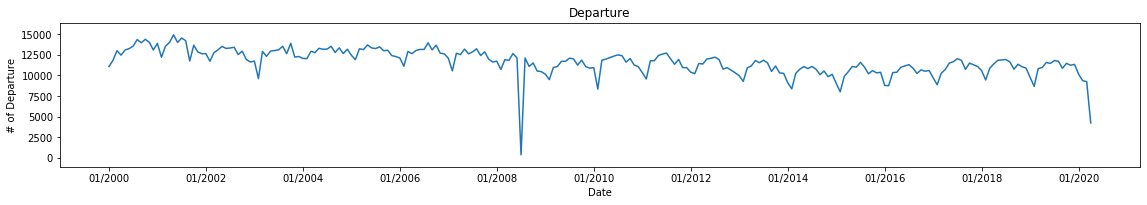

Airport: CLT - Charlotte


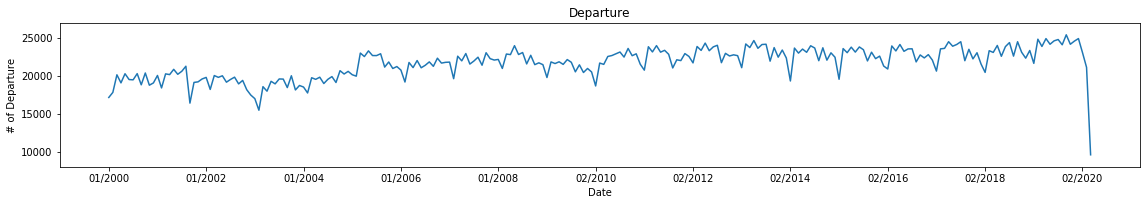

Airport: DCA - Washington


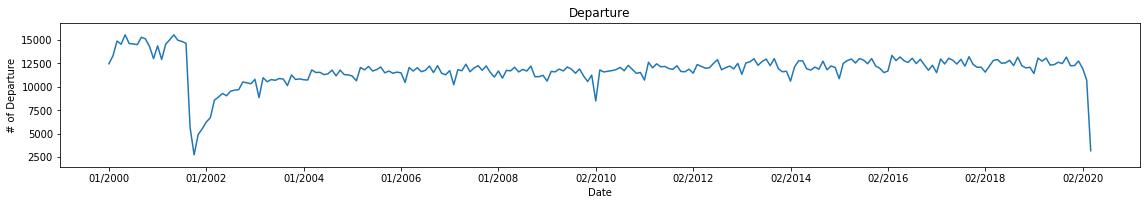

Airport: DEN - Denver


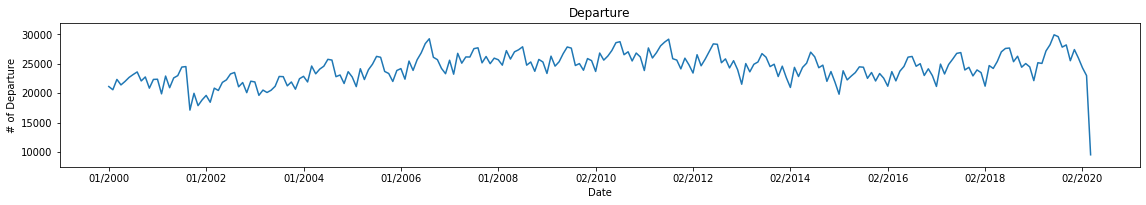

Airport: DFW - Dallas/Ft. Worth


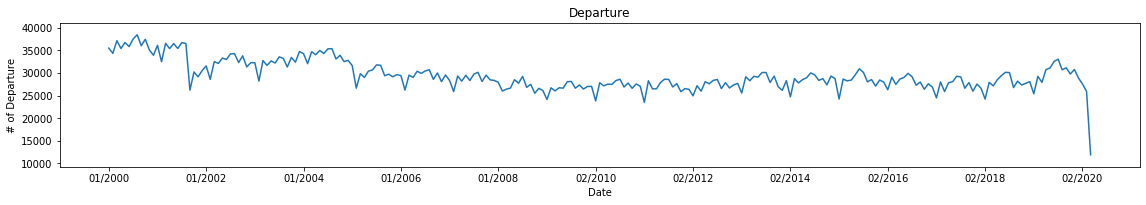

Airport: DTW - Detroit


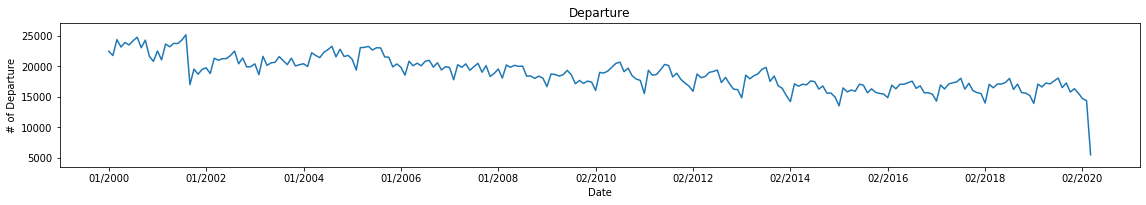

Airport: EWR - Newark


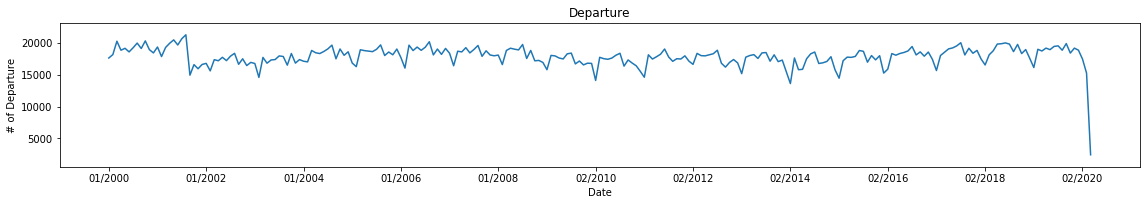

Airport: FLL - Fort Lauderdale


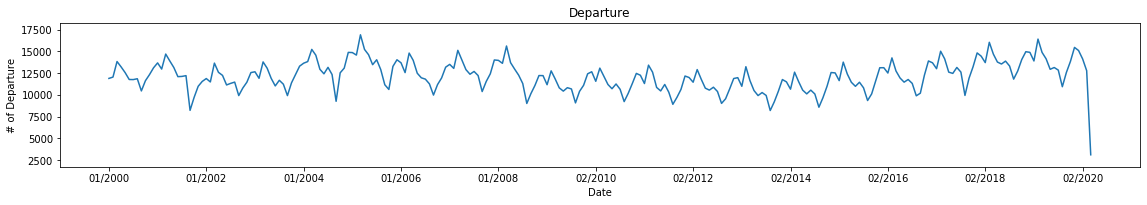

Airport: HNL - Honolulu


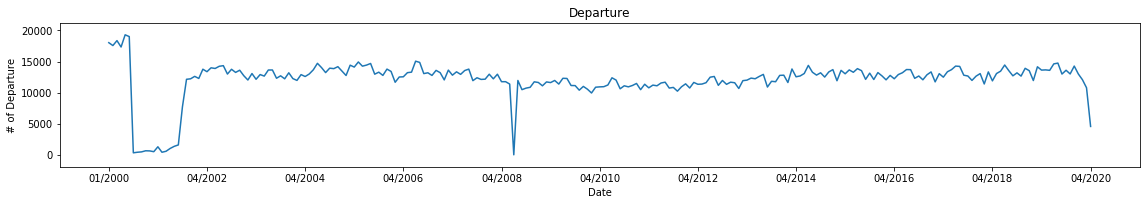

Airport: IAD - Washington


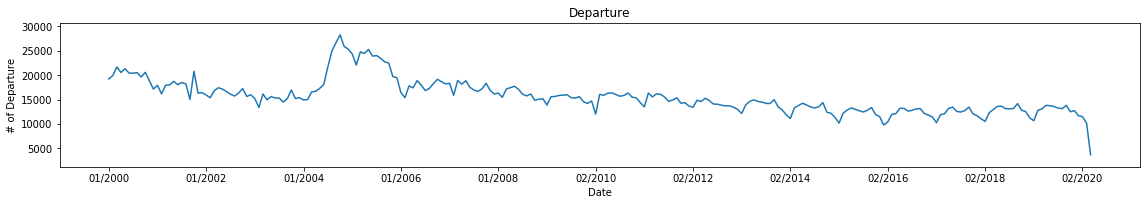

Airport: IAH - Houston


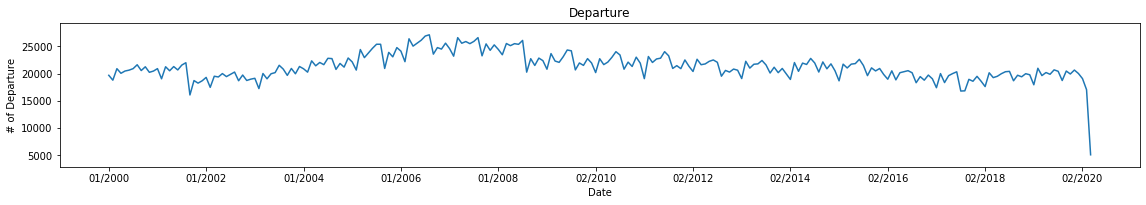

Airport: JFK - New York


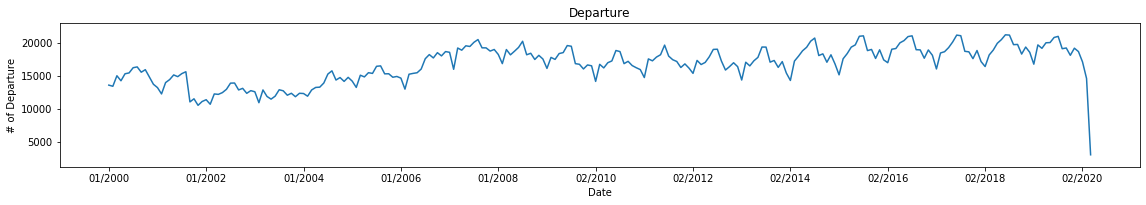

Airport: LAS - Las Vegas


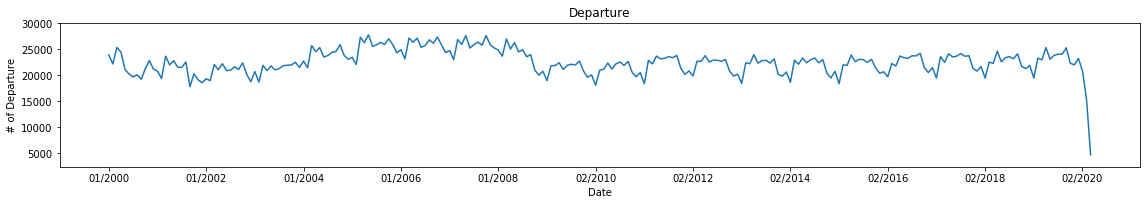

Airport: LAX - Los Angeles


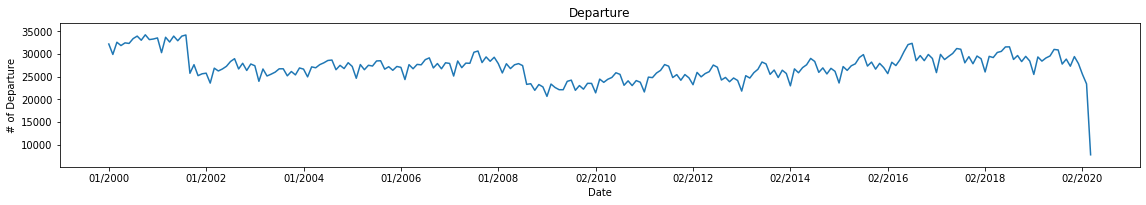

Airport: LGA - New York


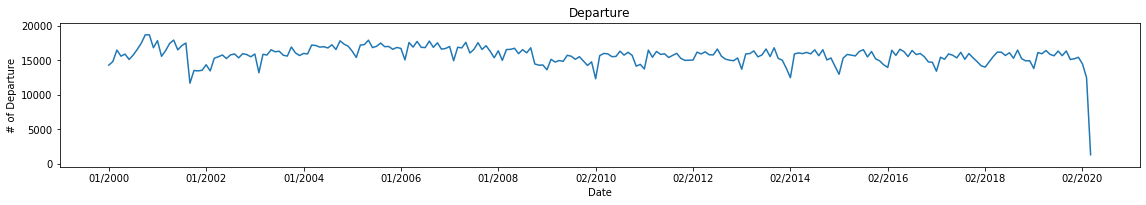

Airport: MCO - Orlando


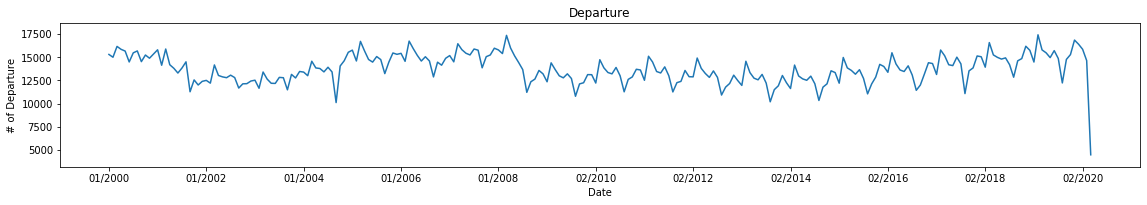

Airport: MDW - Chicago


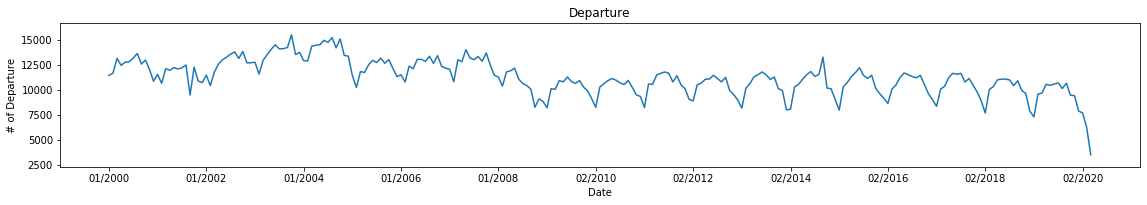

Airport: MEM - Memphis


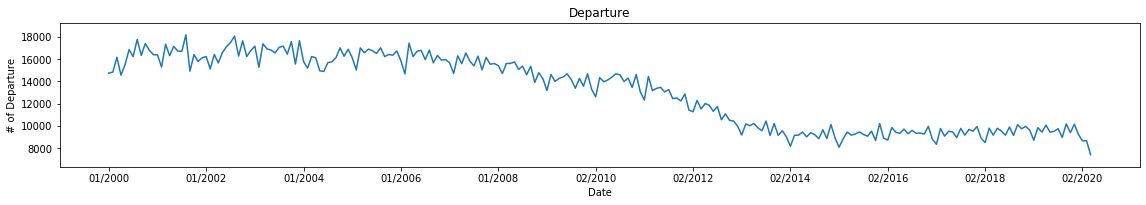

Airport: MIA - Miami


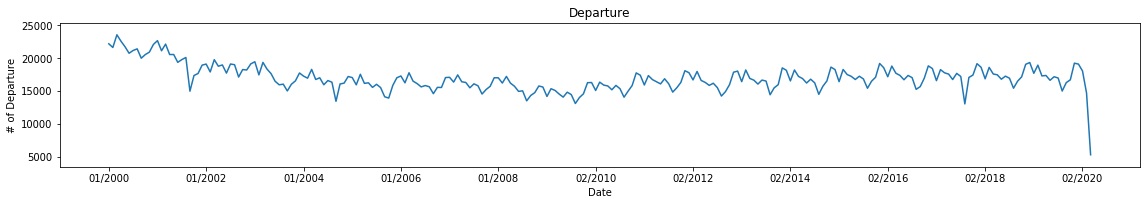

Airport: MSP - Minneapolis


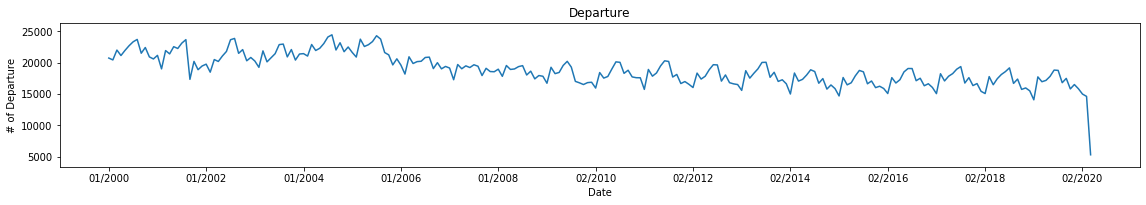

Airport: ORD - Chicago


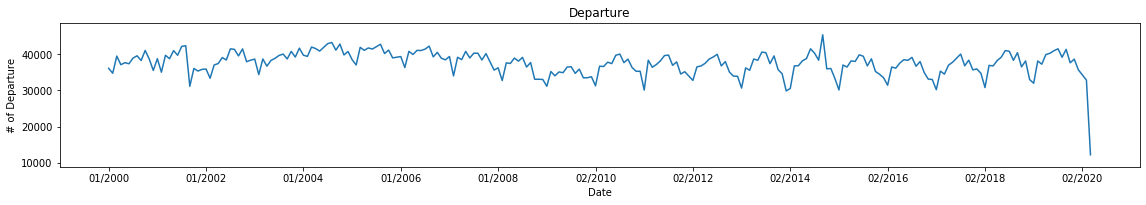

Airport: PHL - Philadelphia


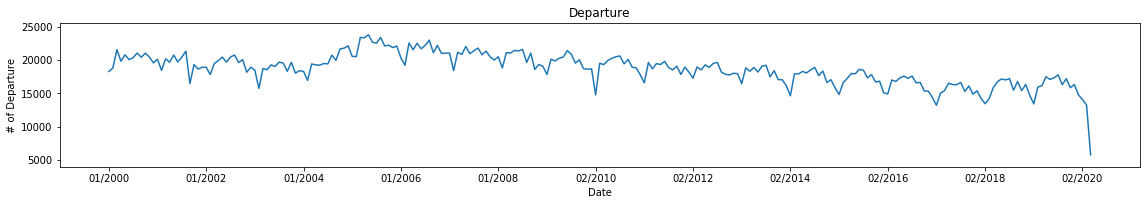

Airport: PHX - Phoenix


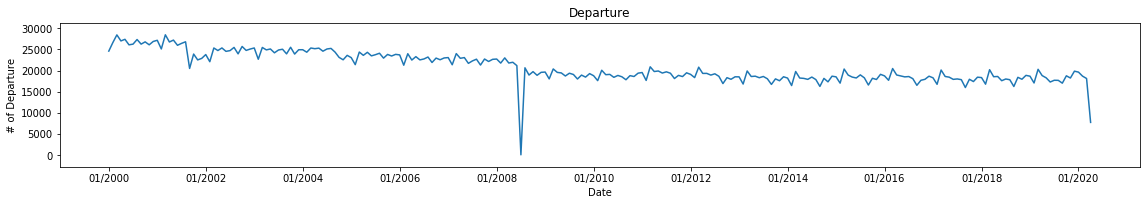

Airport: SAN - San Diego


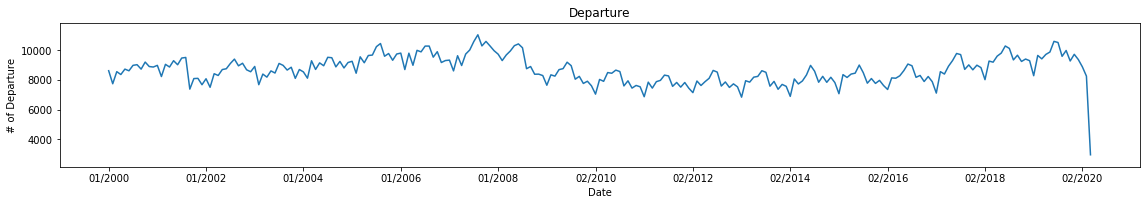

Airport: SEA - Seattle


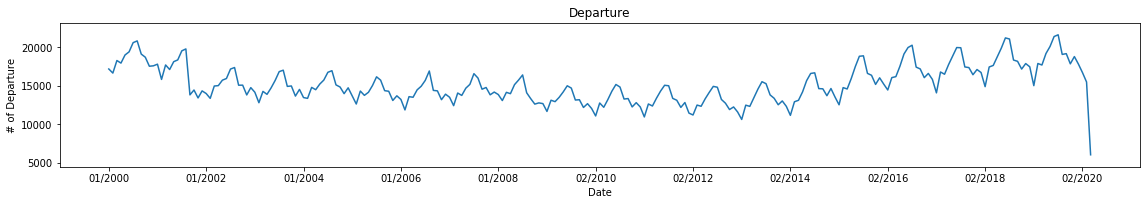

Airport: SFO - San Francisco


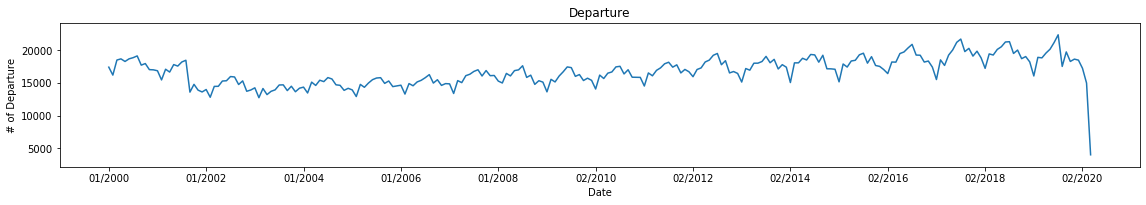

Airport: SLC - Salt Lake City


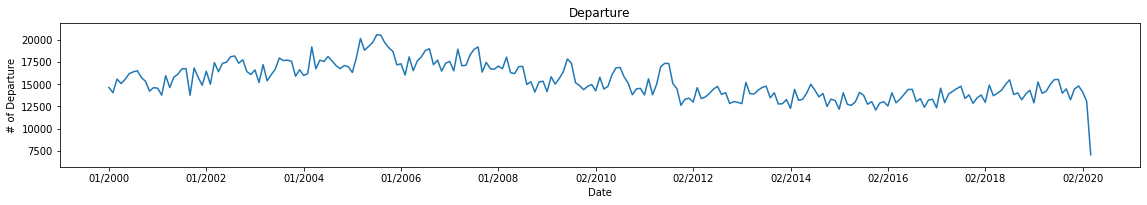

Airport: TPA - Tampa


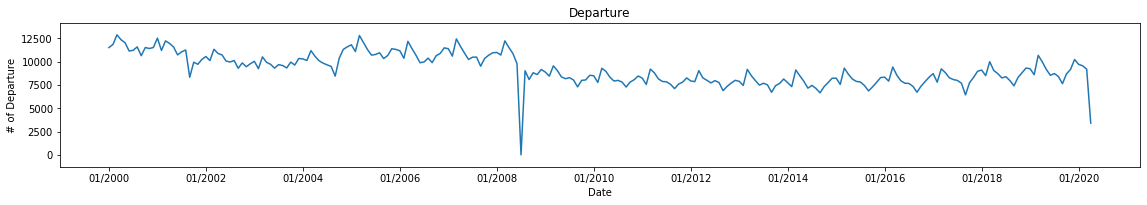

Airport: ATL - Atlanta


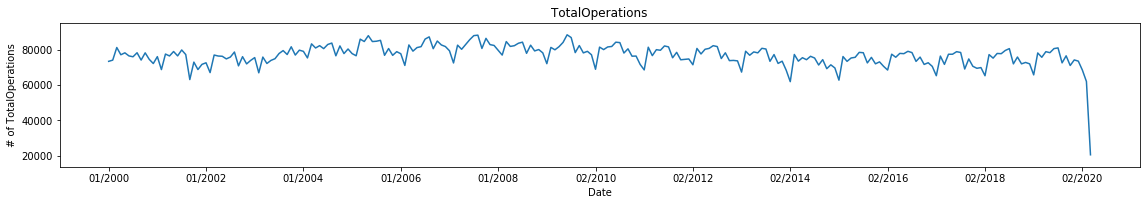

Airport: BOS - Boston


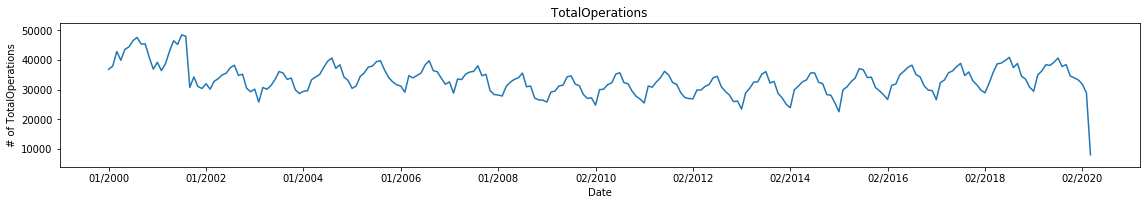

Airport: BWI - Baltimore


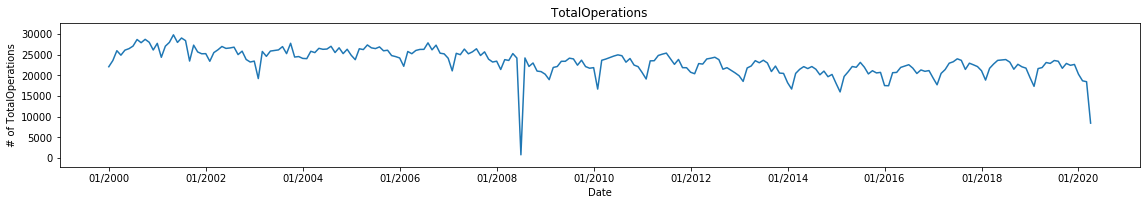

Airport: CLT - Charlotte


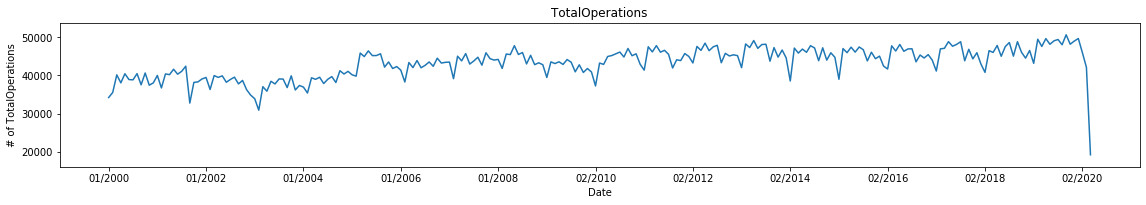

Airport: DCA - Washington


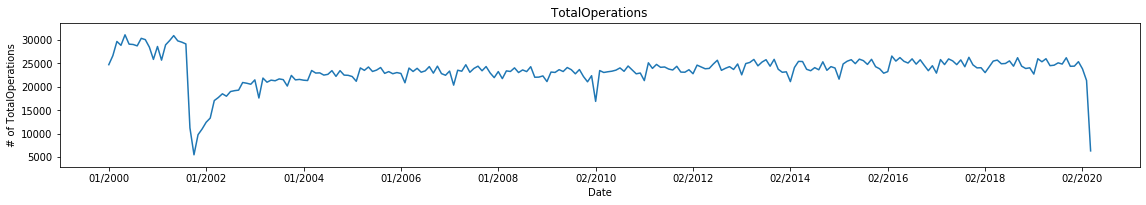

Airport: DEN - Denver


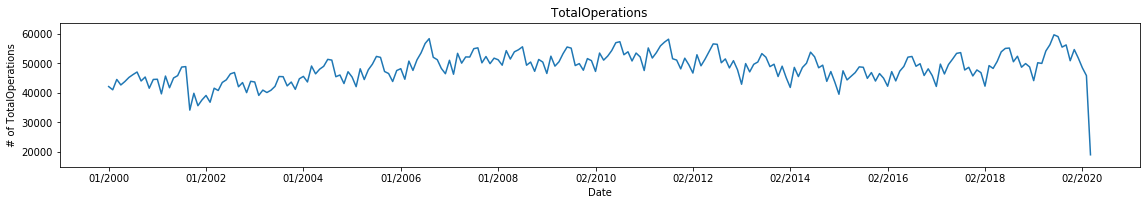

Airport: DFW - Dallas/Ft. Worth


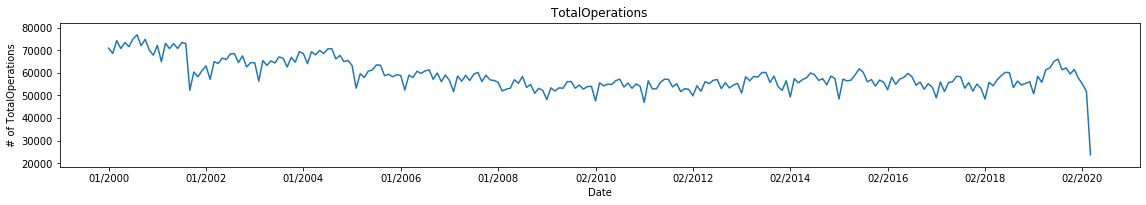

Airport: DTW - Detroit


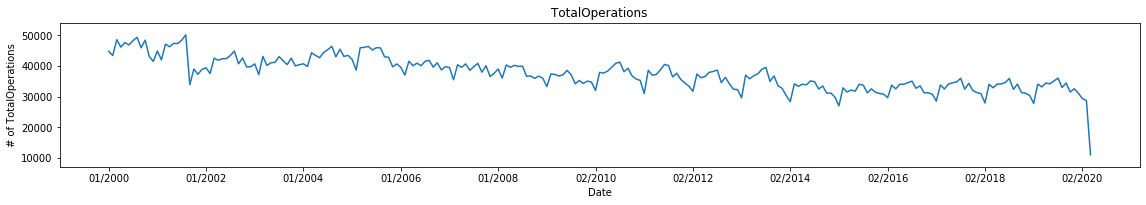

Airport: EWR - Newark


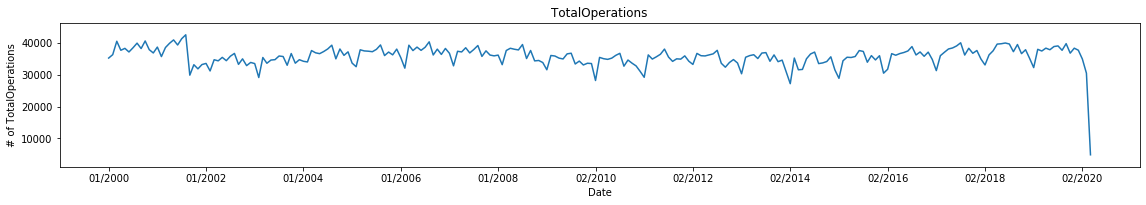

Airport: FLL - Fort Lauderdale


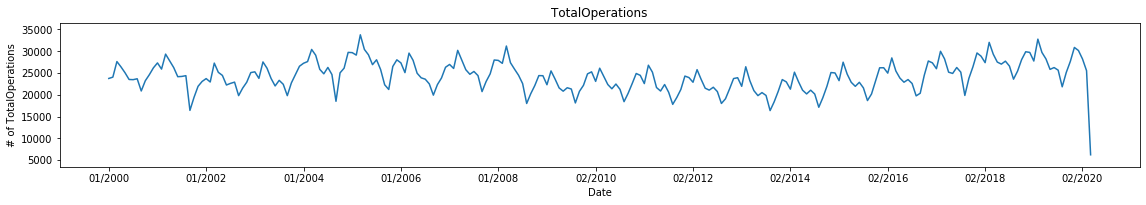

Airport: HNL - Honolulu


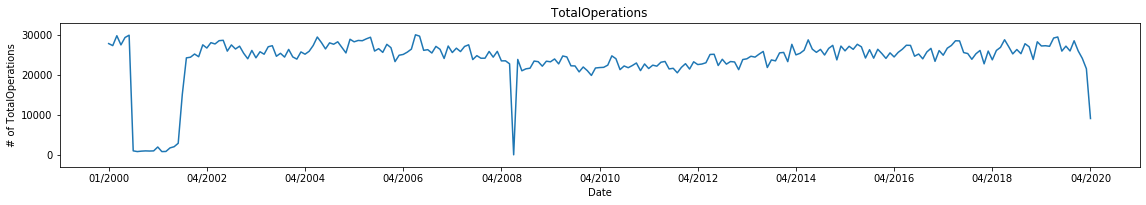

Airport: IAD - Washington


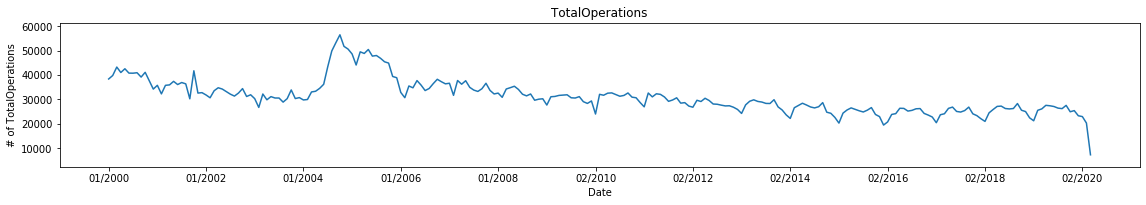

Airport: IAH - Houston


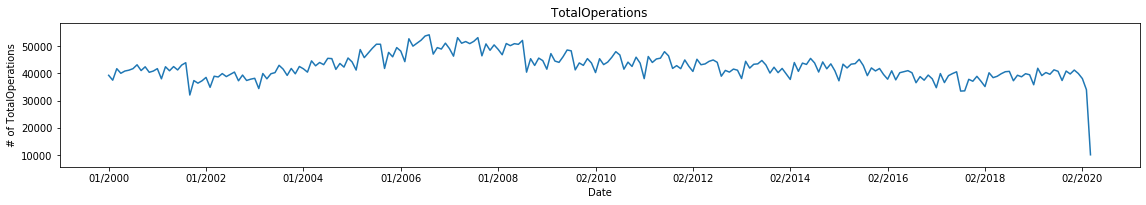

Airport: JFK - New York


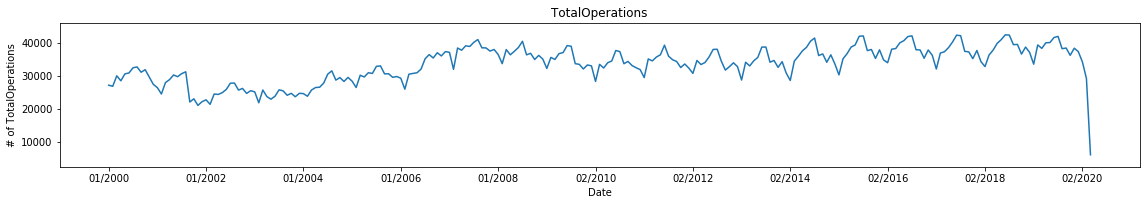

Airport: LAS - Las Vegas


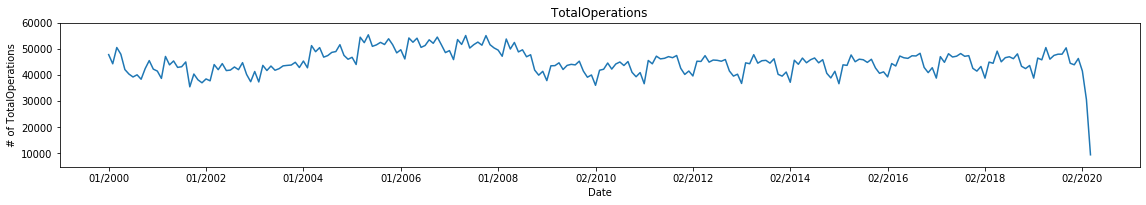

Airport: LAX - Los Angeles


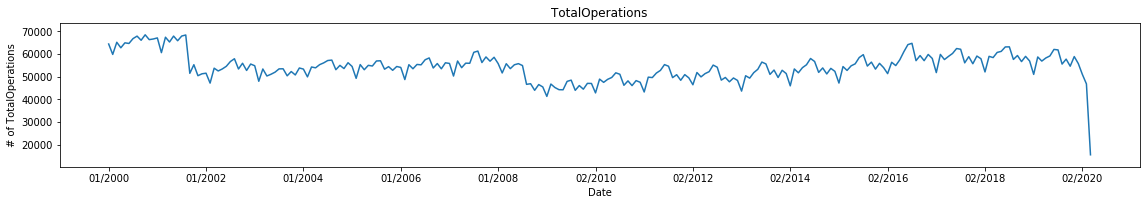

Airport: LGA - New York


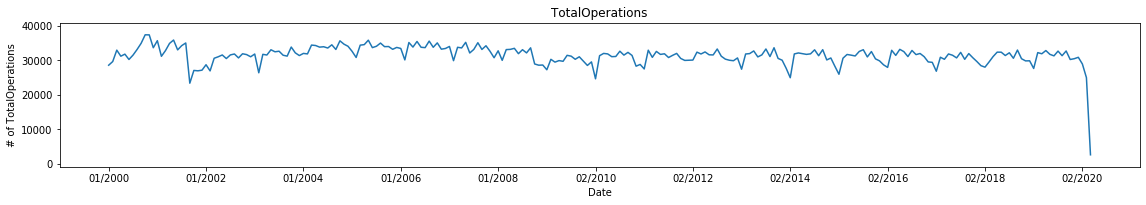

Airport: MCO - Orlando


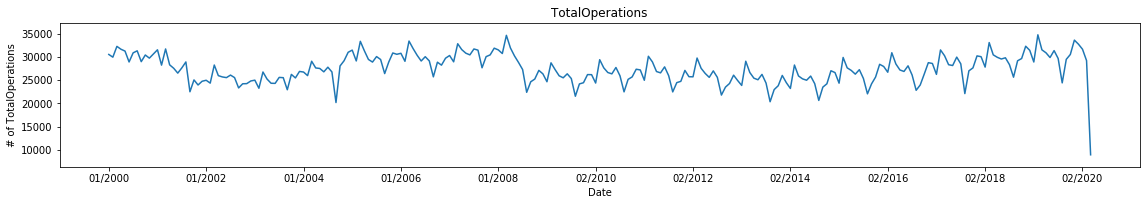

Airport: MDW - Chicago


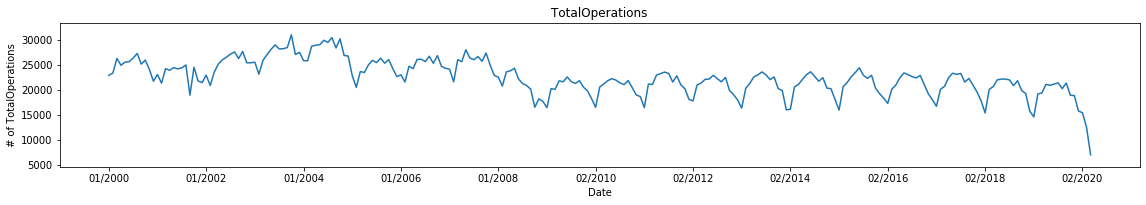

Airport: MEM - Memphis


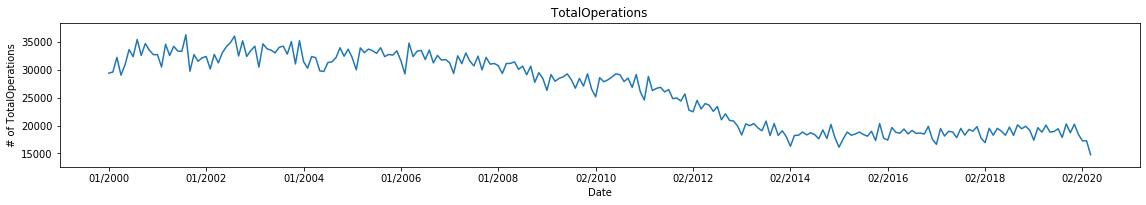

Airport: MIA - Miami


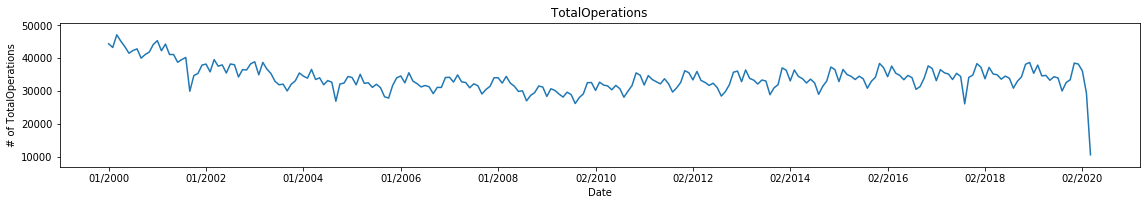

Airport: MSP - Minneapolis


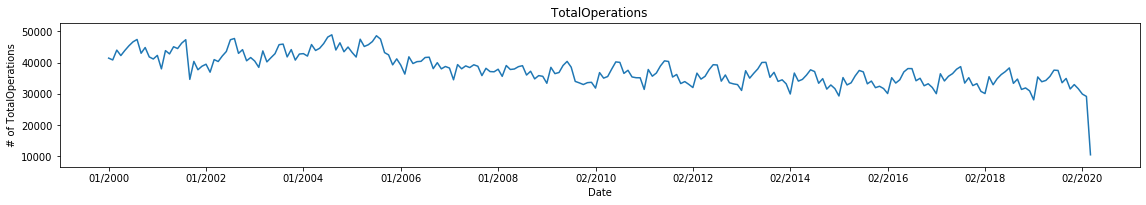

Airport: ORD - Chicago


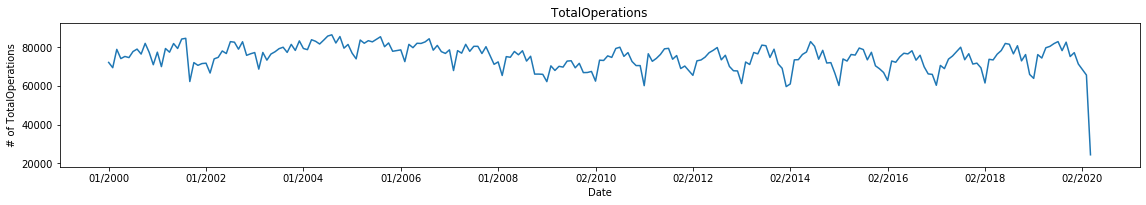

Airport: PHL - Philadelphia


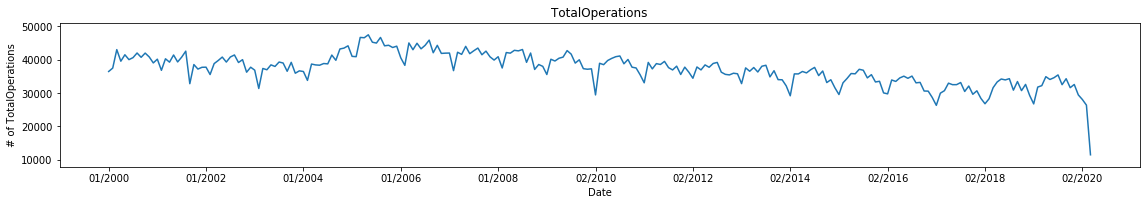

Airport: PHX - Phoenix


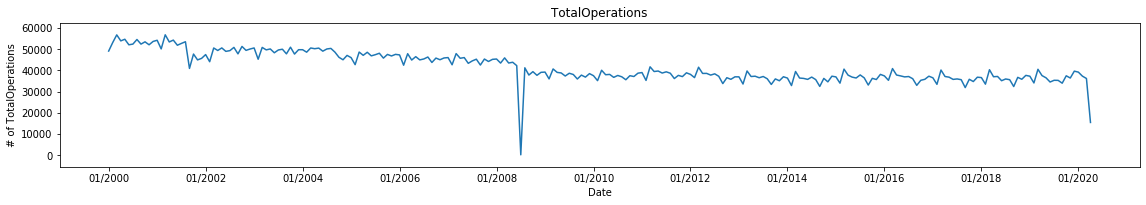

Airport: SAN - San Diego


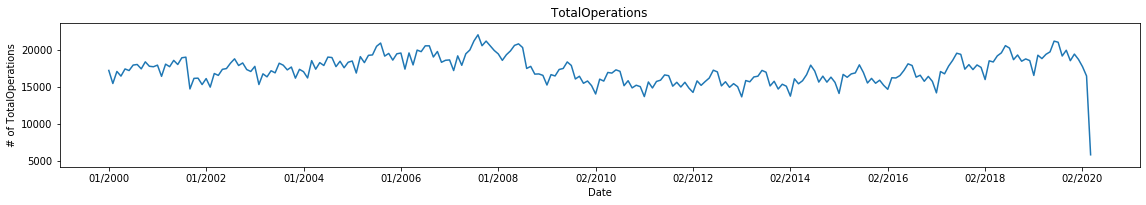

Airport: SEA - Seattle


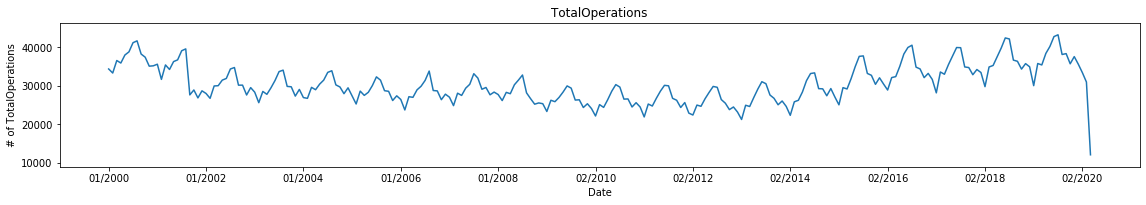

Airport: SFO - San Francisco


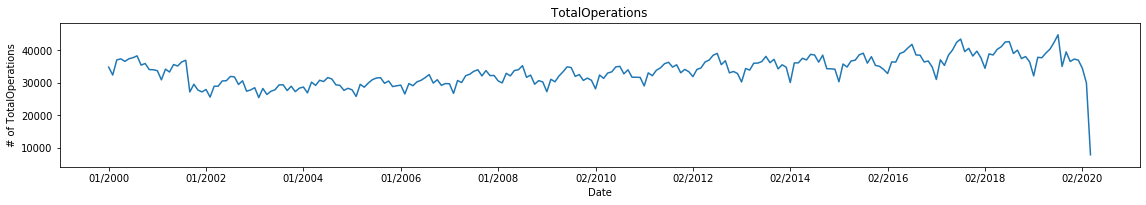

Airport: SLC - Salt Lake City


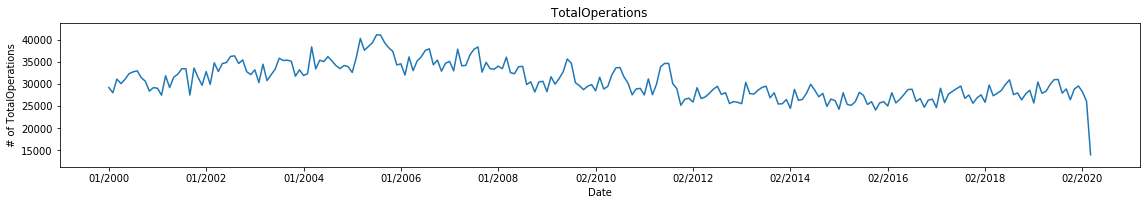

Airport: TPA - Tampa


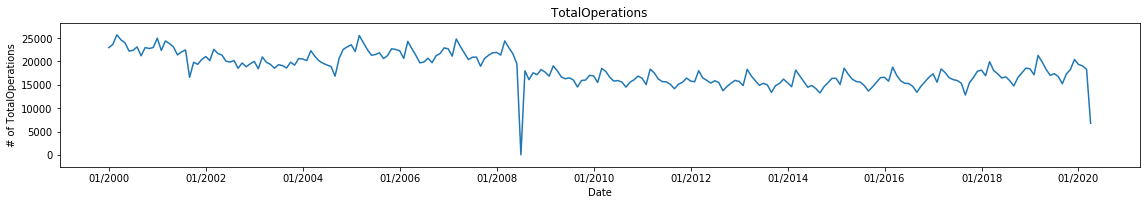

In [9]:
from matplotlib import pyplot as plt
from matplotlib import axes

def plot_cat(cat):
    for apt in airports_data:
    
        fig = plt.figure(figsize=(15,2))
        axes=fig.add_axes([0,0,1,1])

        print('Airport: {}'.format(apt))
        df = airports_data[apt]
    
        axes.set_title(cat)

        plt.xlabel('Date')
        plt.ylabel('# of {}'.format(cat))
        
        vals = []
        
        for val in df[cat]:
            vals.append(int(val.replace(',','')))

        low = min(vals)
        high = max(vals)
 
        rng =  high - low
        axes.set_ylim(ymin=int(low - rng * .1),ymax=int(high + rng * .1))
    
        frq = 10

        step = max(int(len(df['Date'])/frq),1)
        tck=range(0,len(df['Date']),step)
    
        tck_dates = []
        for i in tck:
            tck_dates.append(df['Date'][i])
        plt.xticks(tck,tck_dates)
    

        axes.plot(df['Date'],vals)
        
        plt.show()
        
cat = input('enter one of the following categories to plot [all, Arrival, Departure, TotalOperations]: ')
if cat == 'all':
    plot_cat('Arrival')
    plot_cat('Departure')
    plot_cat('TotalOperations')
else:
    plot_cat(cat)